# Introduction

In this notebook, we explore the differences between the current implementation of stock management by the company against our proposed implementation of a defined Reorder Point and Economic Order Quantity for each product. This approach aims at balancing inventory levels while reducing costs, with the Reorder Point taking into account lead time so that the company's inventory still meet demand while waiting for new stocks.

# Importing Necessary packages

In [50]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

# Loading the Dataset

In [ ]:
database_path = "/app/input/supply_chain.db"

conn = sqlite3.connect(database_path)

In [52]:
# Loading Product Info
query = '''
    SELECT *
    FROM product_info
'''

product_info = pd.read_sql_query(query, conn)

display(product_info.head())

,Product Name,Weight (kg),Product Id,Warehouse Id,Daily Storage Rate,Daily Storage Cost,Manufacturing Time,Manufacturing Cost,Price
0,Perfect Fitness Perfect Rip Deck,3.38,365,4,0.02,0.0676,4,41.99,59.990002
1,Under Armour Girls' Toddler Spine Surge Runni,0.61,627,5,0.02,0.0122,5,16.00,39.990001
2,Nike Men's Dri-FIT Victory Golf Polo,1.52,502,5,0.02,0.0304,10,25.00,50.000000
3,Under Armour Men's Compression EV SL Slide,1.50,278,3,0.02,0.0300,6,18.00,44.990001
4,Under Armour Women's Micro G Skulpt Running S,3.81,249,3,0.02,0.0762,5,38.48,54.970001


In [53]:
# Loading Stock data
query = '''
    SELECT *
    FROM stock_data
    WHERE Date < '2016-01-01';
'''

stock_data = pd.read_sql_query(query, conn)

stock_data = stock_data[stock_data['Product Name'].isin(product_info['Product Name'])]
stock_data["Date"] = pd.to_datetime(stock_data["Date"])

display(stock_data.head())

,Product Name,Date,Current Stock,Total Sold
0,Bag Boy Beverage Holder,2015-01-01,136,0
1,Bag Boy Beverage Holder,2015-01-02,132,4
2,Bag Boy Beverage Holder,2015-01-03,132,0
3,Bag Boy Beverage Holder,2015-01-04,129,3
4,Bag Boy Beverage Holder,2015-01-05,129,0


In [54]:
# Merging the two dataframes to obtain the inventory details
inventory_2015 = stock_data.merge(product_info[["Product Name", "Daily Storage Cost", "Manufacturing Cost"]], on="Product Name", how="inner")

# Setting the index to Product Name
inventory_2015.set_index('Product Name', inplace=True)

display(inventory_2015.head())

,Date,Current Stock,Total Sold,Daily Storage Cost,Manufacturing Cost
Product Name,,,,,
Bag Boy Beverage Holder,2015-01-01,136,0,0.035,10.0
Bag Boy Beverage Holder,2015-01-02,132,4,0.035,10.0
Bag Boy Beverage Holder,2015-01-03,132,0,0.035,10.0
Bag Boy Beverage Holder,2015-01-04,129,3,0.035,10.0
Bag Boy Beverage Holder,2015-01-05,129,0,0.035,10.0


# Calculation of the business total manufacturing and holding costs based on their existing methods of inventory management

Based on their existing methods of inventory management, the company accumulates $464,792.79 in terms of spending on holding costs.

In [55]:
inventory_initial_method = []
total_manufacturing_cost = 0
total_holding_cost = 0
previous_inventory = {}

inventory_2015 = inventory_2015.sort_values(by=["Date", "Product Name"])

# Iterate over each row in the inventory data
for index, row in inventory_2015.iterrows():
    date, today_inventory, quantity_sold, manufacturing_cost, holding_cost = row["Date"], row["Current Stock"], row["Total Sold"], row["Manufacturing Cost"], row["Daily Storage Cost"]
    product = index
    
    # Get previous day's inventory (initialize if first entry for the product)
    if product in previous_inventory:
        yesterday_inventory = previous_inventory[product]
    else:
        yesterday_inventory = today_inventory
    
    # Calculate expected inventory after sales
    expected_inventory = yesterday_inventory - quantity_sold
    
    # Check if an order was placed (today's inventory is greater than expected)
    if today_inventory > expected_inventory:
        order_quantity = today_inventory - expected_inventory
        manufacturing_cost_for_day = manufacturing_cost * order_quantity  # Fixed cost per order
        total_manufacturing_cost += manufacturing_cost_for_day
    else:
        order_quantity = 0
        manufacturing_cost_for_day = 0
    
    # Calculate holding cost for the day
    holding_cost_for_day = today_inventory * holding_cost
    total_holding_cost += holding_cost_for_day
    
    # Store today's data in daily calculations
    inventory_initial_method.append({
        "Date": date,
        "Product Name": product,
        "Current Inventory": today_inventory,
        "Quantity Sold": quantity_sold,
        "Order Quantity": order_quantity,
        "Manufacturing Cost": manufacturing_cost_for_day,
        "Holding Cost": holding_cost_for_day,
        "Total Manufacturing Cost": total_manufacturing_cost,
        "Total Holding Cost": total_holding_cost
    })
    
    # Update previous inventory for the next iteration
    previous_inventory[product] = today_inventory

# Convert daily calculations to DataFrame for analysis
inventory_initial_method = pd.DataFrame(inventory_initial_method)

print(f"Total Holding Cost using the company's initial methods of restocking: ${np.round(total_holding_cost, 2)}")
display(inventory_initial_method.head())

Total Holding Cost using the company's initial methods of restocking: $464792.79


,Date,Product Name,Current Inventory,Quantity Sold,Order Quantity,Manufacturing Cost,Holding Cost,Total Manufacturing Cost,Total Holding Cost
0,2015-01-01,Bag Boy Beverage Holder,136,0,0,0.00,4.7600,0.00,4.7600
1,2015-01-01,Bridgestone e6 Straight Distance NFL Carolina,100,0,0,0.00,8.2600,0.00,13.0200
2,2015-01-01,Bridgestone e6 Straight Distance NFL San Dieg,102,3,3,47.97,1.8156,47.97,14.8356
3,2015-01-01,Bridgestone e6 Straight Distance NFL Tennesse,69,4,4,63.96,5.6994,111.93,20.5350
4,2015-01-01,Clicgear 8.0 Shoe Brush,84,2,2,8.00,5.6448,119.93,26.1798


# Proposed Solution: Inventory Optimization via Economic Order Quantity and setting of reorder point
Based on the proposed solution of Reorder Point with Economic Order Quantity, the company accumulates $428,699.92 in terms of spending on holding costs.

# Preparing 2015 order data

In [56]:
# Loading Product Info
query = '''
    SELECT "Product Name", "Order Month", SUM("Total Quantity Purchased") AS "Total Quantity Purchased"
    FROM cleaned_order_data
    WHERE "Order Date" < '2016-01-01'
    GROUP BY "Product Name", "Order Month";
'''

order_data = pd.read_sql_query(query, conn)

# Month mapping
month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# Convert Order Month to numerical values
order_data['Order Month'] = order_data['Order Month'].map(month_mapping)
order_data = order_data.sort_values(by=['Product Name', 'Order Month'])

display(order_data.head())

,Product Name,Order Month,Total Quantity Purchased
4,Bag Boy Beverage Holder,1,39
3,Bag Boy Beverage Holder,2,17
7,Bag Boy Beverage Holder,3,37
0,Bag Boy Beverage Holder,4,37
8,Bag Boy Beverage Holder,5,34


## Calculating Economic Order Quantity and Reorder Point
- Economic Order Quantity is calculated by sqrt(2 x Total Quantity Purchased * Manufacturing Cost / Storage Cost in a year): It is the amount to restock by.
- Reorder Point is calculated as the average weekly demand * manufacturing time: It is the threshold at which one reorders once stock falls below this threhold.


In [57]:
# Calculating Economic Order Quantity
order_data_info = order_data.groupby('Product Name')['Total Quantity Purchased'].sum().reset_index()
order_data_info = pd.merge(product_info, order_data_info, on='Product Name', how='left')
order_data_info['Economic Order Quantity'] = round(np.sqrt((2 * order_data_info['Total Quantity Purchased'] * order_data_info['Manufacturing Cost'] / (order_data_info['Daily Storage Cost'] * 365))), 0)

# Calculating Reorder Point
order_data_info['Avg Weekly Demand'] = round(order_data_info['Total Quantity Purchased'] / 52, 0)
order_data_info['Reorder Point'] = round(order_data_info['Avg Weekly Demand'] * order_data_info['Manufacturing Time'], 0)

display(order_data_info.head())

,Product Name,Weight (kg),Product Id,Warehouse Id,Daily Storage Rate,Daily Storage Cost,Manufacturing Time,Manufacturing Cost,Price,Total Quantity Purchased,Economic Order Quantity,Avg Weekly Demand,Reorder Point
0,Perfect Fitness Perfect Rip Deck,3.38,365,4,0.02,0.0676,4,41.99,59.990002,26755,302.0,515.0,2060.0
1,Under Armour Girls' Toddler Spine Surge Runni,0.61,627,5,0.02,0.0122,5,16.00,39.990001,11761,291.0,226.0,1130.0
2,Nike Men's Dri-FIT Victory Golf Polo,1.52,502,5,0.02,0.0304,10,25.00,50.000000,22840,321.0,439.0,4390.0
3,Under Armour Men's Compression EV SL Slide,1.50,278,3,0.02,0.0300,6,18.00,44.990001,412,37.0,8.0,48.0
4,Under Armour Women's Micro G Skulpt Running S,3.81,249,3,0.02,0.0762,5,38.48,54.970001,328,30.0,6.0,30.0


In [58]:
# Getting Starting Inventory for 2015
starting_stock_2015 = stock_data[stock_data['Date'] == '2015-01-01']
starting_stock_2015 = starting_stock_2015.drop(['Total Sold', 'Date'], axis=1)
display(starting_stock_2015.head())

# Creating demand variable
demand_data = stock_data.drop(['Current Stock'], axis=1)
display(demand_data.head())

,Product Name,Current Stock
0,Bag Boy Beverage Holder,136
365,Bridgestone e6 Straight Distance NFL Carolina,100
730,Bridgestone e6 Straight Distance NFL San Dieg,102
1095,Bridgestone e6 Straight Distance NFL Tennesse,69
1460,Clicgear 8.0 Shoe Brush,84


,Product Name,Date,Total Sold
0,Bag Boy Beverage Holder,2015-01-01,0
1,Bag Boy Beverage Holder,2015-01-02,4
2,Bag Boy Beverage Holder,2015-01-03,0
3,Bag Boy Beverage Holder,2015-01-04,3
4,Bag Boy Beverage Holder,2015-01-05,0


In [59]:
all_order_data = pd.merge(order_data_info, starting_stock_2015, on='Product Name', how='left')
all_order_data.set_index('Product Name', inplace=True)

display(all_order_data.head())

,Weight (kg),Product Id,Warehouse Id,Daily Storage Rate,Daily Storage Cost,Manufacturing Time,Manufacturing Cost,Price,Total Quantity Purchased,Economic Order Quantity,Avg Weekly Demand,Reorder Point,Current Stock
Product Name,,,,,,,,,,,,,
Perfect Fitness Perfect Rip Deck,3.38,365,4,0.02,0.0676,4,41.99,59.990002,26755,302.0,515.0,2060.0,2901
Under Armour Girls' Toddler Spine Surge Runni,0.61,627,5,0.02,0.0122,5,16.00,39.990001,11761,291.0,226.0,1130.0,1290
Nike Men's Dri-FIT Victory Golf Polo,1.52,502,5,0.02,0.0304,10,25.00,50.000000,22840,321.0,439.0,4390.0,2270
Under Armour Men's Compression EV SL Slide,1.50,278,3,0.02,0.0300,6,18.00,44.990001,412,37.0,8.0,48.0,90
Under Armour Women's Micro G Skulpt Running S,3.81,249,3,0.02,0.0762,5,38.48,54.970001,328,30.0,6.0,30.0,70


In [60]:
# Simulation of implement ROP and EOQ
inventory_EOQ_ROP = []
total_manufacturing_cost = 0
total_holding_cost = 0

demand_data = demand_data.sort_values(by=['Date', 'Product Name'])

for day in demand_data['Date'].unique():
    day_data = demand_data[demand_data['Date'] == day]

    for _, row in day_data.iterrows():
        product_name = row['Product Name']
        demand = row['Total Sold']

        all_order_data.at[product_name, 'Current Stock'] -= demand
        daily_holding_cost = all_order_data.at[product_name, 'Current Stock'] * all_order_data.at[product_name, 'Daily Storage Cost']
        total_holding_cost += daily_holding_cost

        if all_order_data.at[product_name, 'Current Stock'] <= all_order_data.at[product_name, 'Reorder Point']:
            all_order_data.at[product_name, 'Current Stock'] += all_order_data.at[product_name, 'Economic Order Quantity']

            EOQ_cost = all_order_data.at[product_name, 'Economic Order Quantity'] * all_order_data.at[product_name, 'Manufacturing Cost']
            total_manufacturing_cost += EOQ_cost

        inventory_EOQ_ROP.append({
            "Date": day,
            "Product Name": product_name,
            "Inventory Level": all_order_data.at[product_name, 'Current Stock'],
            "Daily Holding Cost": daily_holding_cost,
            "Total Manufacturing Cost": total_manufacturing_cost,
            "Total Holding Cost": total_holding_cost
        })


In [61]:
inventory_EOQ_ROP = pd.DataFrame(inventory_EOQ_ROP)

print(f"Total Holding Cost using Economic Order Quantity for Reorder Point: ${np.round(total_holding_cost, 2)}")

display(inventory_EOQ_ROP.head())

Total Holding Cost using Economic Order Quantity for Reorder Point: $428699.92


,Date,Product Name,Inventory Level,Daily Holding Cost,Total Manufacturing Cost,Total Holding Cost
0,2015-01-01,Bag Boy Beverage Holder,136,4.7600,0.0,4.7600
1,2015-01-01,Bridgestone e6 Straight Distance NFL Carolina,100,8.2600,0.0,13.0200
2,2015-01-01,Bridgestone e6 Straight Distance NFL San Dieg,99,1.7622,0.0,14.7822
3,2015-01-01,Bridgestone e6 Straight Distance NFL Tennesse,65,5.3690,0.0,20.1512
4,2015-01-01,Clicgear 8.0 Shoe Brush,82,5.5104,0.0,25.6616


# Cross comparison for one sample

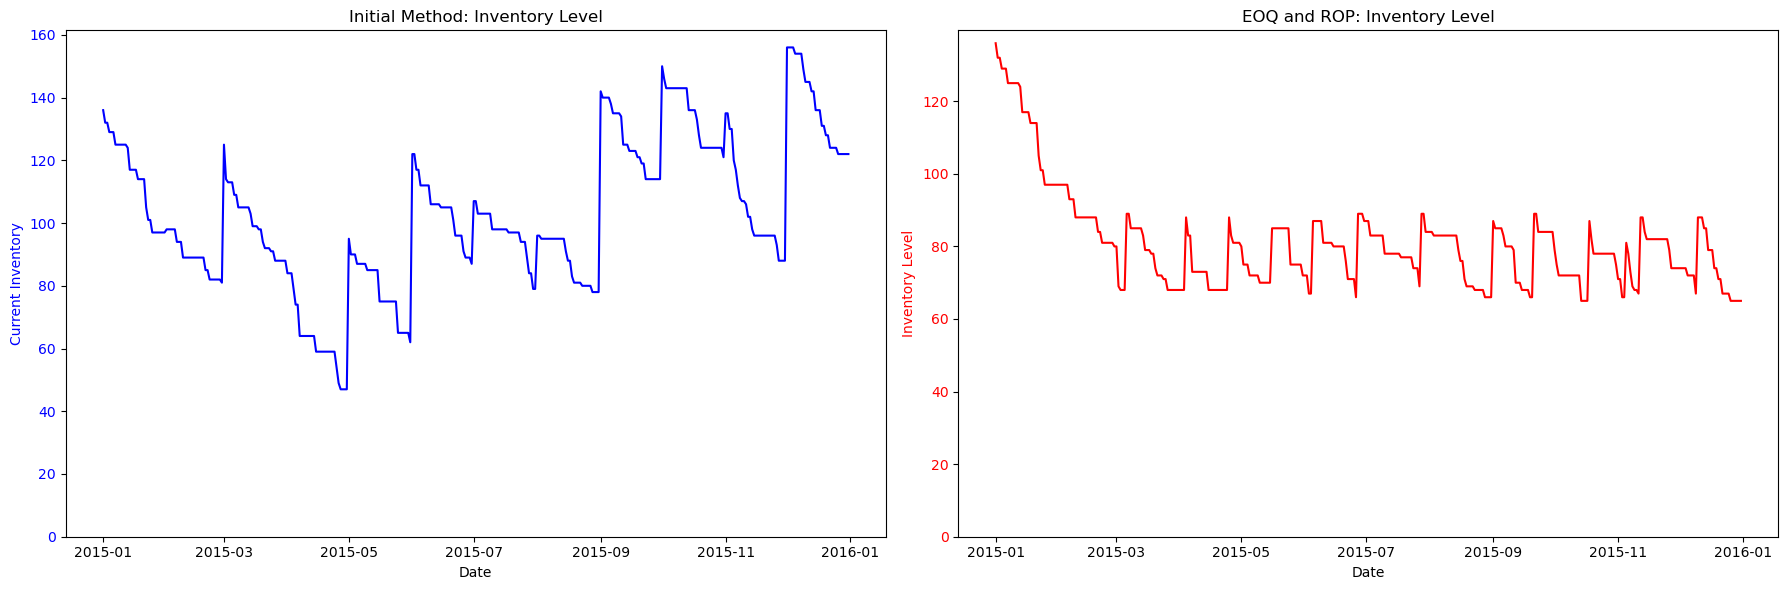

In [62]:
all_initial_method = inventory_initial_method[inventory_initial_method['Product Name'] == 'Bag Boy Beverage Holder']
all_inventory_EOQ_ROP = inventory_EOQ_ROP[inventory_EOQ_ROP['Product Name'] == 'Bag Boy Beverage Holder']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot for all_initial_method
ax1.plot(all_initial_method['Date'], all_initial_method['Current Inventory'], label="Current Inventory", color='blue')
ax1.set_xlabel("Date")
ax1.set_ylabel("Current Inventory", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title("Initial Method: Inventory Level")
ax1.set_ylim(0)  # Set y-axis to start from 0

# Plot for all_inventory_EOQ_ROP
ax2.plot(all_inventory_EOQ_ROP['Date'], all_inventory_EOQ_ROP['Inventory Level'], label="Inventory Level", color='red')
ax2.set_xlabel("Date")
ax2.set_ylabel("Inventory Level", color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_title("EOQ and ROP: Inventory Level")
ax2.set_ylim(0)  # Set y-axis to start from 0

plt.tight_layout()
plt.show()


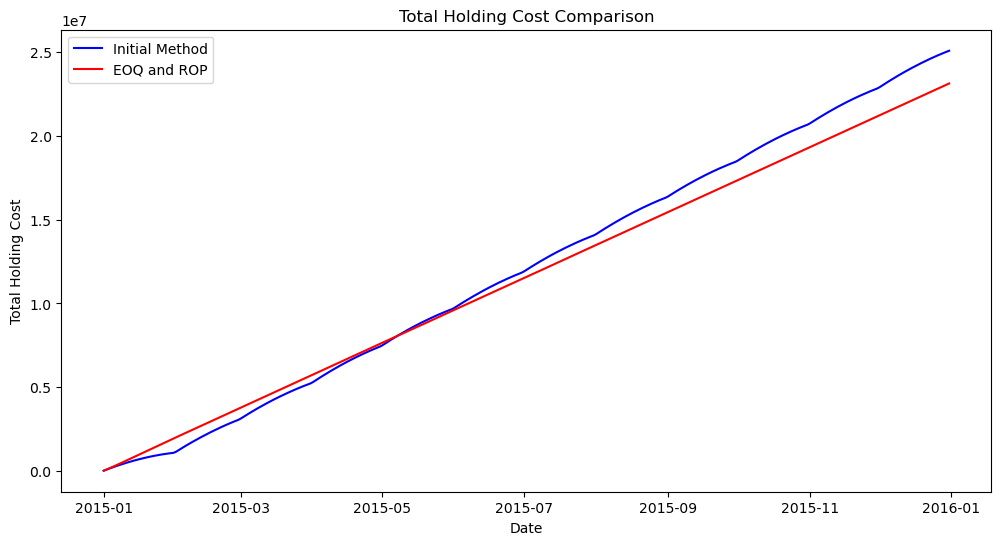

In [63]:
all_initial_method = inventory_initial_method.groupby('Date')['Total Holding Cost'].sum().reset_index()
all_inventory_EOQ_ROP = inventory_EOQ_ROP.groupby('Date')['Total Holding Cost'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(all_initial_method['Date'], all_initial_method['Total Holding Cost'], label="Initial Method", color='blue')
plt.plot(all_inventory_EOQ_ROP['Date'], all_inventory_EOQ_ROP['Total Holding Cost'], label="EOQ and ROP", color='red')
plt.xlabel("Date")
plt.ylabel("Total Holding Cost")
plt.title("Total Holding Cost Comparison")
plt.legend()
plt.show()

# Conclusion

With the proposed implementation of EOQ and ROP, the company are able to save money in terms of Holding costs, which amounts to $36,092.87.